Note : I have executed this code in google collab so when executing locally the path and the device might be different 

In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

Using GPU if available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mounting Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Train File

In [3]:
# Load the dataset
file_path = '/content/drive/MyDrive/BITS-Sarvesh/Fourth year/ML/Data/train.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

Preprocessing data

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data.drop('Target', axis=1))
# Assuming your data is stored in a pandas DataFrame called 'df'
preprocessed_data = pd.DataFrame(scaled_features, columns=data.columns[:-1])
preprocessed_data['Target'] = data['Target'].values

Preprocessing the Data by using standard scalr and handling the outliers

1. This is just one of the method I tried but I really did not go ahed with it as it did not make any significant difference in the accuracy of the training results 

In [ ]:
# # Load the dataset
# file_path = 'Data/train.csv'  # Replace with your actual file path
# data = pd.read_csv(file_path)

# # Feature Scaling: Using StandardScaler for scaling features
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(data.drop('Target', axis=1))

# # Handling Outliers: Capping outliers at 1.5 times the IQR
# for col in data.columns[:-1]:  # Excluding the target column
#     Q1 = data[col].quantile(0.25)
#     Q3 = data[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# # Re-scaling the data after handling outliers
# scaled_data = scaler.fit_transform(data.drop('Target', axis=1))

# # Creating a new DataFrame for the preprocessed data
# preprocessed_data = pd.DataFrame(scaled_data, columns=data.columns[:-1])
# preprocessed_data['Target'] = data['Target'].values

# # Displaying the first few rows of the preprocessed data
# preprocessed_data.head()

Building the correlation matrix to check if any 2 features are correlated

In [2]:
# def preprocess_data(file_path, corr_threshold=0.9):
#     # Load the dataset
#     data = pd.read_csv(file_path)

#     # Scaling features using StandardScaler
#     scaler = StandardScaler()
#     scaled_features = scaler.fit_transform(data.drop('Target', axis=1))

#     # Handling outliers by capping at 1.5 times the IQR
#     for col in data.columns[:-1]:  # Excluding the target column
#         Q1 = data[col].quantile(0.25)
#         Q3 = data[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

#     # Re-scaling the data after handling outliers
#     final_scaled_data = scaler.fit_transform(data.drop('Target', axis=1))

#     # Creating a DataFrame for the preprocessed data
#     preprocessed_data = pd.DataFrame(final_scaled_data, columns=data.columns[:-1])
#     preprocessed_data['Target'] = data['Target'].values

#     # Correlation analysis - removing highly correlated features
#     corr_matrix = preprocessed_data.corr().abs()
#     upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#     to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)]
#     preprocessed_data = preprocessed_data.drop(to_drop, axis=1)

#     return preprocessed_data,corr_matrix

In [3]:
# file_path = '../Data/train.csv'  # Replace with your actual file path
# preprocessed_data_with_correlation,corr_matrix = preprocess_data(file_path)

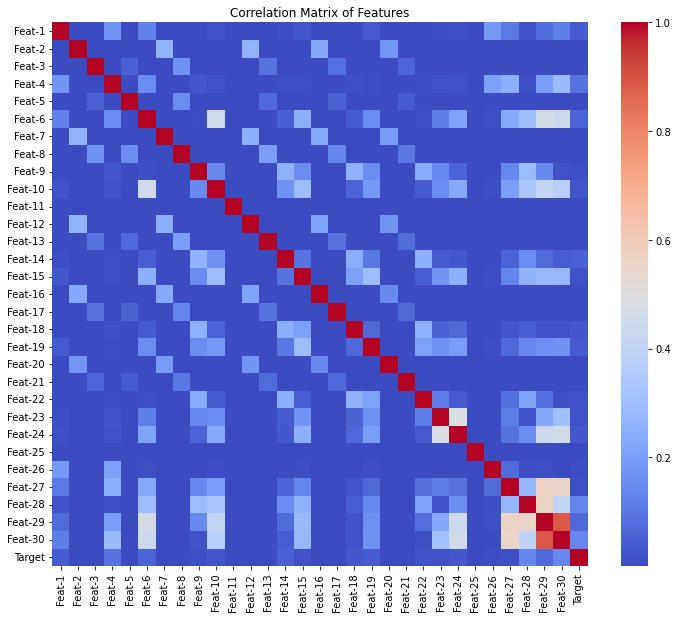

In [4]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plotting the correlation matrix using a heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
# plt.title("Correlation Matrix of Features")
# plt.show()

Converting to Pytorch Tensors

In [ ]:
X = preprocessed_data.drop('Target', axis=1).values
y = preprocessed_data['Target'].values
# Convert numpy arrays to PyTorch tensors
X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)

# Splitting the data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

# Creating data loaders
train_data = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

Defining the Neural Network Structure

1. Preventing overfitting by implementing L1 and L2 regularization 
2. Improving training performance by implementing Batch normalization

In [ ]:
class AdvancedNN(nn.Module):
    def __init__(self, input_size):
        super(AdvancedNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(256)

        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.bn2 = nn.BatchNorm1d(128)

        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.bn1(self.relu1(self.fc1(x))))
        x = self.dropout2(self.bn2(self.relu2(self.fc2(x))))
        x = self.dropout3(self.relu3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))
        return x

In [ ]:
model = AdvancedNN(input_size=X_train.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

Training The Model

In [27]:
# Training loop
epochs = 150
for epoch in range(epochs):
    total = 0
    correct = 0

    for batch in train_loader:
        X_batch, y_batch = batch[0].to(device), batch[1].to(device)
        outputs = model(X_batch)
        predicted = outputs.squeeze().round()
        loss = criterion(outputs.squeeze(), y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%')


Using device: cuda
Epoch [1/150], Loss: 0.5570, Accuracy: 67.59%
Epoch [2/150], Loss: 0.4695, Accuracy: 70.87%
Epoch [3/150], Loss: 0.5399, Accuracy: 71.68%
Epoch [4/150], Loss: 0.5964, Accuracy: 72.02%
Epoch [5/150], Loss: 0.5766, Accuracy: 72.32%
Epoch [6/150], Loss: 0.5128, Accuracy: 72.53%
Epoch [7/150], Loss: 0.4966, Accuracy: 72.78%
Epoch [8/150], Loss: 0.5431, Accuracy: 72.86%
Epoch [9/150], Loss: 0.5777, Accuracy: 72.97%
Epoch [10/150], Loss: 0.4403, Accuracy: 73.08%
Epoch [11/150], Loss: 0.4759, Accuracy: 73.24%
Epoch [12/150], Loss: 0.6277, Accuracy: 73.21%
Epoch [13/150], Loss: 0.4755, Accuracy: 73.33%
Epoch [14/150], Loss: 0.5677, Accuracy: 73.35%
Epoch [15/150], Loss: 0.4591, Accuracy: 73.38%
Epoch [16/150], Loss: 0.5762, Accuracy: 73.47%
Epoch [17/150], Loss: 0.5395, Accuracy: 73.47%
Epoch [18/150], Loss: 0.5115, Accuracy: 73.56%
Epoch [19/150], Loss: 0.4967, Accuracy: 73.56%
Epoch [20/150], Loss: 0.5091, Accuracy: 73.62%
Epoch [21/150], Loss: 0.5526, Accuracy: 73.68%
Epo

Saving The Model

In [28]:
model_save_path = '/content/drive/MyDrive/BITS-Sarvesh/Fourth year/ML/models/model1.pth'
# Saving the model parameters
torch.save(model.state_dict(), model_save_path)
print(f"Model parameters saved to: {model_save_path}")

Model parameters saved to: /content/drive/MyDrive/BITS-Sarvesh/Fourth year/ML/models/model1.pth


Loading the Test data

In [ ]:
# Load the test dataset
test_data_path = '/content/drive/MyDrive/BITS-Sarvesh/Fourth year/ML/Data//test.csv'  # Replace with your actual file path
test_data = pd.read_csv(test_data_path)

Preprocessing the Test Data and converting to pytorch Tensor

In [ ]:
# Remove the ID column and save it for later
test_ids = test_data['ID']
test_features = test_data.drop('ID', axis=1)
# Scaling the features using the previously defined scaler
scaled_test_features = scaler.fit_transform(test_features)
# Converting to PyTorch tensor
test_tensor = torch.tensor(scaled_test_features, dtype=torch.float32).to(device)

Loading the model which is saved from training

In [ ]:
model_save_path = '/content/drive/MyDrive/BITS-Sarvesh/Fourth year/ML/models/model1.pth'
model.load_state_dict(torch.load(model_save_path))

Prediction on Test data using the saved model

In [29]:
# Predicting with the neural network
with torch.no_grad():
    model.eval() # Set the model to evaluation mode
    test_predictions = model(test_tensor).squeeze().round()

# Converting predictions to a NumPy array
test_predictions_np = test_predictions.cpu().numpy()

# Preparing the DataFrame for the output CSV
output_df = pd.DataFrame({'ID': test_ids, 'Target': test_predictions_np})

# Saving the predictions to a CSV file
output_file_path = '/content/drive/MyDrive/BITS-Sarvesh/Fourth year/ML/predicted_results.csv' 
output_df.to_csv(output_file_path, index=False)

print("Predictions saved to:", output_file_path)

Predictions saved to: /content/drive/MyDrive/BITS-Sarvesh/Fourth year/ML/submission1.csv


Creating the submission Zip file

In [ ]:
with zipfile.ZipFile('submission.zip', 'w', zipfile.ZIP_DEFLATED) as archive:
    archive.write('output/submission.csv')
    archive.write('classifier.ipynb')

print('Your submission is now ready!')
print('Upload this file to both kaggle and quanta to get your score')

Other Methods that I have tried out

In [ ]:
# from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# # AdaBoost with Random Forest
# ada_boost_model = AdaBoostClassifier(
#     base_estimator=RandomForestClassifier(n_estimators=150, random_state=42),
#     n_estimators=50,
#     learning_rate=1.0,
#     random_state=42
# )

# # Gradient Boosting
# grad_boost_model = GradientBoostingClassifier(
#     n_estimators=150,
#     learning_rate=0.1,
#     max_depth=3,
#     random_state=42
# )

# # Train and evaluate AdaBoost model
# ada_boost_model.fit(X_train, y_train)
# y_pred_ada = ada_boost_model.predict(X_test)
# accuracy_ada = accuracy_score(y_test, y_pred_ada)

# # Train and evaluate Gradient Boosting model
# grad_boost_model.fit(X_train, y_train)
# y_pred_grad = grad_boost_model.predict(X_test)
# accuracy_grad = accuracy_score(y_test, y_pred_grad)

# accuracy_ada, accuracy_grad